In [1]:
#from barney_functions import add_labels_to_excel,gen_audio_array,buffer,shifter,louder,plot_mel,augment_audio,plot_sample,hsr_loader,lsr_loader,calc_stft,calc_melstft,spec_plot, gen_labels, gen_audio_array_noexcel,augment_audio_faster
from barney_functions import *

In [2]:
import librosa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import re
import os
from tqdm import tqdm 
import soundfile as sf

# Load Zebra

In [3]:
audio_path = 'zebra audio sample_Bing_413/all/'
audio_path_long = 'Audio Files All/'
spreadsheet_path = 'Zebras.Assumption.data_Bing_413 .xlsx'
df = add_labels_to_excel(spreadsheet_path)
audio_files, audio_size, index_longest = gen_audio_array(audio_path,df)
zebra_labels = df['label']

#audio_files, audio_size, filenames_long, longest_file = gen_audio_array_noexcel(audio_path_long)
#zebra_labels = gen_labels(filenames_long)

Finding longest file (Better Labels)


100%|█████████████████████████████████████████| 413/413 [00:21<00:00, 18.94it/s]


Loading files


100%|█████████████████████████████████████████| 413/413 [00:18<00:00, 21.84it/s]


In [4]:
zebra_labels = df['label']
classes = np.unique(zebra_labels)
print(classes)
softsnort_idx = np.where(zebra_labels=='softsnort')
print(softsnort_idx)
softsnorts = audio_files[softsnort_idx]

['snort' 'softsnort' 'squeal' 'whinnie']
(array([162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175]),)


In [5]:
audio_files.shape

(413, 39923)

In [135]:
def balance_stats(audio_files,labels):
    classes = np.unique(labels)
    split_calls = []
    for call in classes:
        call_idx = np.where(labels==call)
        calls = audio_files[call_idx]
        split_calls.append(calls)
    class_rel_pop = np.zeros(len(classes))
    multiplier = np.zeros(len(classes))
    new_multiplier = np.zeros(len(classes))
    balanced = []
    for i in range(len(classes)):
        class_rel_pop[i]=len(split_calls[i])/len(audio_files)
        multiplier[i] = (1/class_rel_pop[i]) - len(classes)
    biggest = np.min(multiplier)
    for j in range(len(multiplier)):
        if multiplier[j] > 0:
            new_multiplier[j] = int(np.abs(multiplier[j]/biggest))
        else:
            new_multiplier[j] = 1
    return np.around(class_rel_pop,3)

def balancer(audio_files,labels):
    print("Initial class proportions:")
    print(balance_stats(audio_files,labels))
    classes = np.unique(labels)
    split_calls = []
    split_labels = []
    for i in range(len(classes)):
        call_idx = np.where(labels==classes[i])
        calls = audio_files[call_idx]
        split_calls.append(calls)
        split_labels.append([classes[i]]*len(split_calls[i]))
    class_rel_pop = np.zeros(len(classes))
    multiplier = np.zeros(len(classes))
    new_multiplier = np.zeros(len(classes))
    for i in range(len(classes)):
        class_rel_pop[i]=len(split_calls[i])/len(audio_files)
        multiplier[i] = (1/class_rel_pop[i]) - len(classes)
    biggest = np.min(multiplier)
    for j in range(len(multiplier)):
        if multiplier[j] > 0:
            new_multiplier[j] = int(np.abs(multiplier[j]/biggest))
        else:
            new_multiplier[j] = 1
    balanced = audio_files
    balanced_labels = np.array(labels)
    for i in range(len(classes)):
        print('----------------------')
        print("Balancing:",classes[i])
        print("Multiplier:",new_multiplier[i])
        for k in range(int(new_multiplier[i]-1)):
            balanced = np.concatenate((balanced, split_calls[i]), axis=0)
            balanced_labels = np.append(balanced_labels,split_labels[i])
    print('----------------------')
    print("DONE")
    print('----------------------')
    print("Final class proportions:")
    print(balance_stats(balanced,balanced_labels))
    return balanced, balanced_labels

In [136]:
balanced, balanced_labels = balancer(audio_files,zebra_labels)

Initial class proportions:
[0.574 0.034 0.092 0.3  ]
----------------------
Balancing: snort
Multiplier: 1.0
----------------------
Balancing: softsnort
Multiplier: 11.0
----------------------
Balancing: squeal
Multiplier: 3.0
----------------------
Balancing: whinnie
Multiplier: 1.0
----------------------
DONE
----------------------
Final class proportions:
[0.377 0.245 0.181 0.197]


# Generate not zebera

In [4]:
nzebra_path = 'big bounce small.wav'
nzebra_audio, labels_nzebra = gen_nzebra(nzebra_path,audio_size)
#save_nzebra(nzebra_audio)

Padding


100%|█████████████████████████████████████| 1620/1620 [00:00<00:00, 2407.83it/s]


In [5]:
all_audio, all_lables = add_nzebra(audio_files,zebra_labels,nzebra_audio,labels_nzebra)

In [6]:
print("Unaugmented dataset size: ",all_audio.nbytes/(1e9), 'GB')

Unaugmented dataset size:  2701.571544 MB


# Augment Audio

In [7]:
augmented_audio = augment_audio_faster_smaller(audio_files)

Augmenting


100%|███████████████████████████████████████| 1719/1719 [00:18<00:00, 93.56it/s]


In [8]:
print(augmented_audio.shape)
print("Augmented dataset size: ",augmented_audio.nbytes/(1e9), 'GB')

(4, 1719, 323637)
Augmented dataset size:  17802.624096 MB


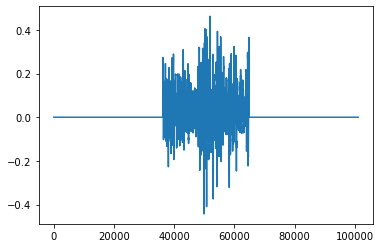

In [9]:
plt.plot(audio_files[400])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


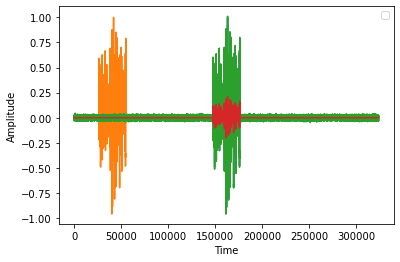

In [10]:
plot_sample(augmented_audio,400)

In [11]:
stfts = calc_stft(augmented_audio)
#mels = calc_melstft(augmented_audio)

Augmentation  1


100%|███████████████████████████████████████| 1719/1719 [00:37<00:00, 46.03it/s]


Augmentation  2


100%|███████████████████████████████████████| 1719/1719 [00:39<00:00, 43.39it/s]


Augmentation  3


100%|███████████████████████████████████████| 1719/1719 [00:50<00:00, 34.35it/s]


Augmentation  4


100%|███████████████████████████████████████| 1719/1719 [00:41<00:00, 41.67it/s]


In [12]:
print(stfts.shape)
print("Augmented dataset size: ",stfts.nbytes/(1e9), 'GB')

(4, 1719, 1025, 633)
Augmented dataset size:  35.6905656 GB


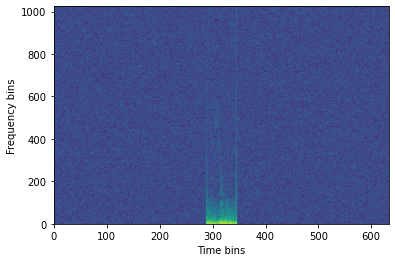

In [13]:
spec_plot(stfts[2,400,:,:])

In [14]:
stfts_1D = np.zeros(stfts[0].shape)
stfts_1D = stfts[0]
for i in tqdm(range(1,stfts.shape[0])):
    stfts_1D = np.concatenate((stfts_1D,stfts[i]), axis = 0)

100%|█████████████████████████████████████████████| 3/3 [04:15<00:00, 85.14s/it]


In [15]:
stfts_1D.shape
print("Dataset size: ",stfts_1D.nbytes/(1e9), 'GB')

Dataset size:  35.6905656 GB


In [16]:
#np.save('stfts_array',stfts)
#stfts = np.load('stfts_array.npy')